## **Movie Recommendation System**

### *Business Understanding*
#### Project Overview

The goal of this project is to develop a machine learning model for streaming service stakeholders, that is able to learn historical information regarding movie consumption by viewers and then generate the most relevant recommendations based on individual preferences and interests. With the advancement in technology, viewers now have access to large collections of movies to choose from. This may make it difficult for viewers to make a decision on what exactly to watch. A scenario described as "choice overload". Such individuals may choose a movie that they may not like or loose interest completely which leads to customer dissatisfaction. A movie recommendation system addresses this challenge by recommending movies that the individual will like based on historical user activity. This will enhance customer engagement, retention and satisfaction.

#### Objectives
- Build a model that will provide 5 top movie recommendations for each individual user.
- Create a feature that will allow users to rate other movies that they have watched.
- Develop a validation strategy that ensures that the model will perform well on unseen data.
- Use a Hybrid approach (Collaborative + Content-Based) to recommend movies with zero ratings

### *Data Understanding*
This project makes use of the MovieLens dataset from the GroupLens research lab at the University of Minnesota.
The MovieLens dataset contains historical information about movie consumption ratings by different viewers(~100,000 user ratings). The folder contains 4 files: links.csv, movies.csv, ratings.csv and tags.csv. These files contain some of the following features:
- User Id
- Movie Id
- Movie Title
- Movie Rating(5 star scale)
- Genres
- Tags

These features enable the model to learn user patterns/preferences regarding the genre of movies they like to watch and as a result it will be able to make informed decisions on which movies to recommend to each individual.

### *Data Preparation*
Data was cleaned using pandas, including merging movie titles with user tags and removing users with fewer than 50 ratings to reduce noise. We engineered a "metadata" feature by combining genres and user tags, which was then processed using Scikit-Learn’s TfidfVectorizer to support content-based filtering. We will use pandas library to read in the information contained within the files into a format we can use. We will clean then preprocess the data before we can fit a machine learning model. Other useful libraries we will use include numpy, matplotlib and seaborn for visualization.

### *Modeling*
We utilized the Surprise Library for an iterative modeling process. We established a performance floor using BaselineOnly, followed by KNNWithMeans for neighborhood-based similarity. The final model, SVD (Singular Value Decomposition), was optimized via GridSearchCV to tune latent factors and regularization, ensuring the model generalizes well to unseen data.

### *Evaluation:*

Models were evaluated using RMSE on a 30% test set. The Tuned SVD outperformed the baseline, proving its utility in providing personalized picks. We also implemented a Hybrid approach utilizing Cosine Similarity as a fallback for the "Cold Start" problem, ensuring new users receive relevant recommendations immediately.


In [1]:
# Loading the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise import Dataset, Reader, SVD, accuracy, BaselineOnly
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


In [2]:
# Reading in the dataset
links = pd.read_csv('../data/links.csv')
print(links.head())
print('\n')
movies = pd.read_csv('../data/movies.csv')
print(movies.head())
print('\n')
ratings = pd.read_csv('../data/ratings.csv')
print(ratings.head())
print('\n')
tags = pd.read_csv('../data/tags.csv')
tags.head()

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931




,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [3]:
# checking for missing values
print(links.isnull().sum())
print('\n')
print(movies.isnull().sum())
print('\n')
print(ratings.isnull().sum())
print('\n')
print(tags.isnull().sum())

movieId    0
imdbId     0
tmdbId     8
dtype: int64


movieId    0
title      0
genres     0
dtype: int64


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [4]:
# checking for duplicates
print(links.duplicated().sum())
print(movies.duplicated().sum())
print(ratings.duplicated().sum())
print(tags.duplicated().sum())

0
0
0
0


In [5]:
ratings.drop(columns = ['timestamp'], inplace = True)
tags.drop(columns = ['timestamp'], inplace = True)

In [6]:
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [7]:
# combining tags for each movie into a single string
tags_combined = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
# merge tags with movies dataframe
movies_tags = pd.merge(movies, tags_combined, on='movieId', how='left')
movies_tags.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake


In [8]:
# calculating the number of unique users and movies
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
length_ratings = len(ratings)
print(f'Number of unique users: {num_users}')
print(f'Number of unique movies: {num_movies}')
print(f'Total number of ratings: {length_ratings}')
# calculating the sparsity of the ratings matrix
sparsity = 1 - (length_ratings / (num_users * num_movies))
print(f'Sparsity of the ratings matrix: {sparsity:.4f}')


Number of unique users: 610
Number of unique movies: 9724
Total number of ratings: 100836
Sparsity of the ratings matrix: 0.9830


In [9]:
# Only keep users with more than 50 ratings
user_counts = ratings['userId'].value_counts()
active_users = user_counts[user_counts >= 50].index
ratings_filtered = ratings[ratings['userId'].isin(active_users)]

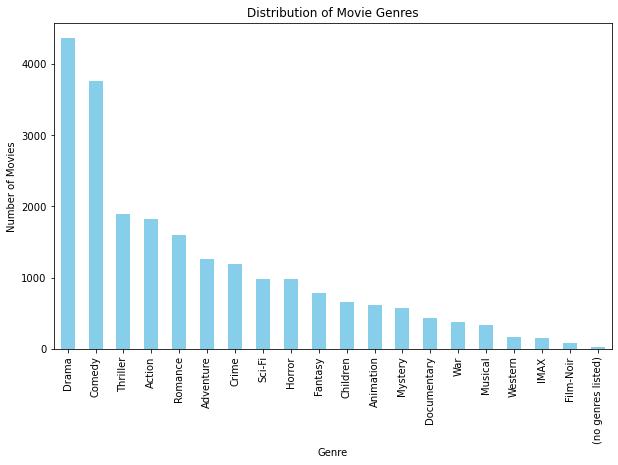

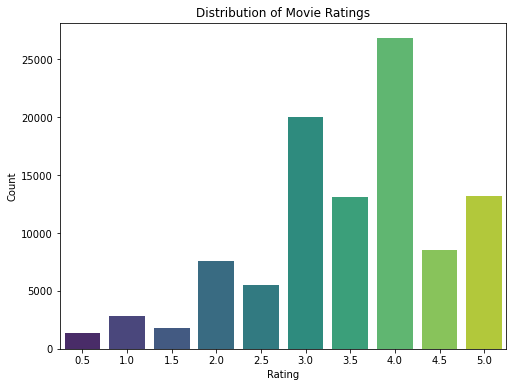

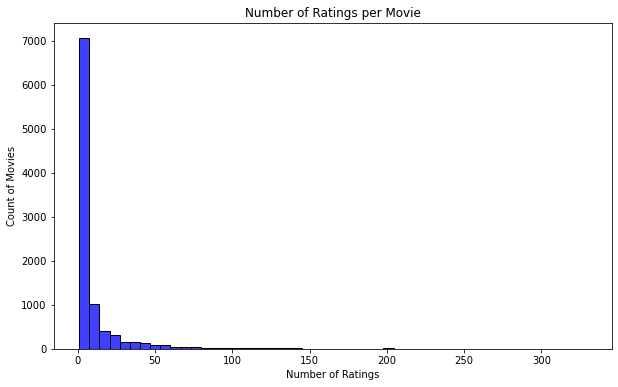

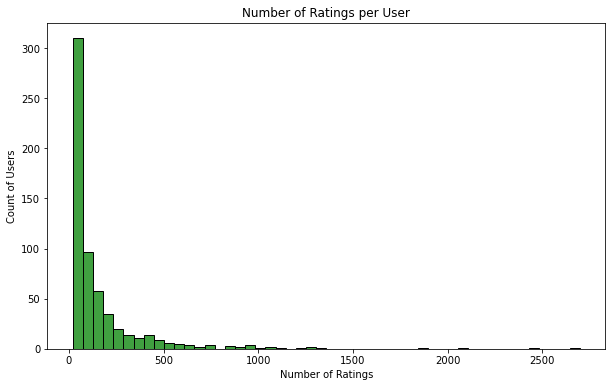

In [10]:
# Split the genres and create a list of all instances
genre_series = movies['genres'].str.split('|').explode()    
# Plot the top genres
plt.figure(figsize=(10,6))
genre_series.value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.show()
# visualizing the distribution of ratings
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
# visualizing the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size()
plt.figure(figsize=(10,6))
sns.histplot(ratings_per_movie, bins=50, kde=False, color='blue')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()
# visualizing the number of ratings per user
ratings_per_user = ratings.groupby('userId').size()
plt.figure(figsize=(10,6))
sns.histplot(ratings_per_user, bins=50, kde=False, color='green')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()


In [11]:
# Merge movies and ratings to see titles
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Count ratings per movie
top_rated_movies = movie_ratings.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

# Display result
print("Top 10 Most Frequently Rated Movies:")
print(top_rated_movies)

Top 10 Most Frequently Rated Movies:
title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64


### *Iterative Modeling*

We will build several models including a baseline model by iteratively modeling to find the best one that fits our data. we will use the RMSE and MAE to compare models. A lower RMSE implies a better model.

#### Model 1: BaselineOnly

We use BaselineOnly to account for the "average" rating and the specific "bias" of users (e.g., some users always rate low).

In [12]:
# defining a reader for the surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# splitting the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

In [13]:
# baseline model
baseline_model = BaselineOnly()
baseline_model.fit(trainset)
baseline_predictions = baseline_model.test(testset)
baseline_rmse = accuracy.rmse(baseline_predictions)
print(f'Baseline Model RMSE: {baseline_rmse:.4f}')


Estimating biases using als...
RMSE: 0.8764
Baseline Model RMSE: 0.8764


#### Model 2: KNNWithMeans


our second model is the KNNWithMeans. It finds and uses 'movie twins' or similar users as a basis for recommendations.

In [14]:
# knnWithMeans model
knnWM_model = KNNWithMeans(sim_options={'name': 'pearson', 'user_based': True})
knnWM_model.fit(trainset)
knnWM_predictions = knnWM_model.test(testset)
knnWM_rmse = accuracy.rmse(knnWM_predictions)
print(f'KNNWithMeans Model RMSE: {knnWM_rmse:.4f}')

improvement = baseline_rmse - knnWM_rmse
print(f'Improvement over Baseline: {improvement:.4f}')

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9071
KNNWithMeans Model RMSE: 0.9071
Improvement over Baseline: -0.0307


In [15]:
# making a prediction for a specific user and movie
user_id = 9999
movie_id = 1
knnWM_model.predict(user_id, movie_id)

Prediction(uid=9999, iid=1, r_ui=None, est=3.501615074024226, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

while KnnWithMeans's RMSE might be higher, it offers personalization that the Baseline doesn't. 

#### Model 3: SVD

The third model is svd and we use this because it handles sparse data efficiently. We used GridSearchCV from the Surprise library to systematically test hyperparameter combinations, ensuring the model doesn't overfit to the training data.

In [16]:
#Tuned svd model with hyperparameter tuning
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1, 0.4] 
}
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
svd_gs.fit(data)
# best SVD model from grid search
best_svd_params = svd_gs.best_params['rmse']
print(f'Best SVD parameters: {best_svd_params}')
best_svd_model = SVD(**best_svd_params)
best_svd_model.fit(trainset)
svd_predictions = best_svd_model.test(testset)
svd_rmse = accuracy.rmse(svd_predictions)
print(f'SVD Model RMSE: {svd_rmse:.4f}')
improvement_svd = baseline_rmse - svd_rmse
print(f'Improvement over Baseline: {improvement_svd:.4f}')

Best SVD parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
RMSE: 0.8706
SVD Model RMSE: 0.8706
Improvement over Baseline: 0.0058


In [17]:
# making a prediction for a specific user and movie
user_id = 9999
movie_id = 1  
best_svd_model.predict(user_id, movie_id)

Prediction(uid=9999, iid=1, r_ui=None, est=3.87873931377938, details={'was_impossible': False})

we compare the three models in order to find the best model, i.e. one with the lowest RMSE.

Final Model Performance Comparison:


,RMSE
Model,
Tuned SVD,0.870615
Baseline (Bias Only),0.876383
KNNWithMeans,0.907079


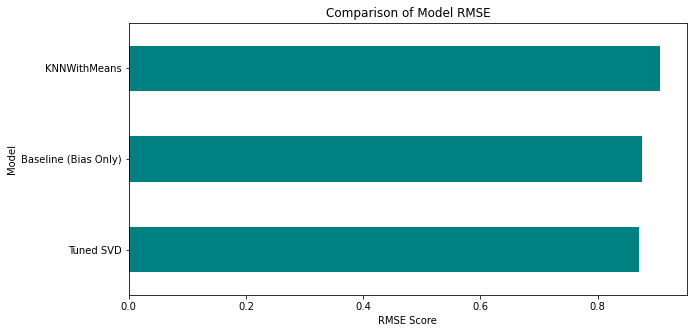

In [18]:
# BaselineOnly, KNNWithMeans, and Tuned SVD comparison
comparison_data = {
    'Model': ['Baseline (Bias Only)', 'KNNWithMeans', 'Tuned SVD'],
    'RMSE': [baseline_rmse, knnWM_rmse, svd_rmse]
    }

comparison_df = pd.DataFrame(comparison_data)
comparison_df.set_index('Model', inplace=True)

# Sort by RMSE to easily identify the best model
comparison_df.sort_values(by='RMSE', ascending=True, inplace=True)

print("Final Model Performance Comparison:")
display(comparison_df)

# Visualize the Comparison
comparison_df['RMSE'].plot(kind='barh', color='teal', figsize=(10, 5))
plt.title('Comparison of Model RMSE')
plt.xlabel('RMSE Score')
plt.show()


In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Obtaining User ratings

In [20]:
# Function to rate movies
def movie_rater(movies, num, genre=None):
    # Filter by genre if specified; otherwise use the full list
    if genre:
        # Uses pandas .str.contains to find the genre within the 'genres' column
        movie_pool = movies[movies['genres'].str.contains(genre, case=False)]
    else:
        movie_pool = movies.copy()
    
    rating_list = []
    
    # Continue until we have collected the requested number (num) of ratings
    while len(rating_list) < num:
        # Randomly sample one movie from the pool
        movie = movie_pool.sample(1).iloc[0]
        
        print(f"\nMovie: {movie['title']}")
        rating = input("Rate this movie 1-5 (or press 's' to skip if unseen): ")
        
        if rating.lower() == 's':
            continue
            
        try:
            rating_val = float(rating)
            if 1 <= rating_val <= 5:
                # Store the rating in the required dictionary format
                rating_list.append({
                    'userId': 1000, # Placeholder for your current user ID
                    'movieId': int(movie['movieId']),
                    'rating': rating_val
                })
            else:
                print("Please enter a number between 1 and 5.")
        except ValueError:
            print("Invalid input. Please enter a number or 's'.")
            
    return rating_list

#### The Hybrid Recommender

Collaborative filtering fails for new users (Cold Start). We solve this by using a content-based fallback using TF-IDF.

In [21]:
# Combine metadata and create similarity matrix
movies_tags['metadata'] = movies_tags['genres'].str.replace('|', ' ') + " " + movies_tags['tag'].fillna('')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_tags['metadata'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# The Hybrid Function Logic ---
def get_hybrid_rec(user_id, movie_title=None, model=best_svd_model):
    # If User is NEW (Cold Start)
    if user_id not in ratings_filtered['userId'].unique():
        print(f"Cold Start: Recommending movies similar to '{movie_title}'...")
        idx = movies_tags[movies_tags['title'] == movie_title].index[0]
        sim_scores = sorted(list(enumerate(cosine_sim[idx])), key=lambda x: x[1], reverse=True)[1:6]
        return movies_tags.iloc[[i[0] for i in sim_scores]][['title', 'genres']]
    
    # If User is EXISTING (SVD)
    else:
        all_ids = movies['movieId'].unique()
        rated = ratings_filtered[ratings_filtered['userId'] == user_id]['movieId'].unique()
        preds = [model.predict(user_id, m) for m in all_ids if m not in rated]
        preds.sort(key=lambda x: x.est, reverse=True)
        top_5_ids = [p.iid for p in preds[:5]]
        return movies[movies['movieId'].isin(top_5_ids)][['title', 'genres']]

# --- STEP C: Integrating the User Input ---
# 1. Get new ratings from the user
new_user_ratings = movie_rater(movies, 5, genre='Comedy')

# 2. Convert to DataFrame and append to ratings_filtered
new_ratings_df = pd.DataFrame(new_user_ratings)
updated_ratings = pd.concat([ratings_filtered, new_ratings_df], ignore_index=True)

# 3. Trigger Recommendation based on the first movie they liked (Hybrid Logic)
first_movie_liked = movies[movies['movieId'] == new_user_ratings[0]['movieId']]['title'].values[0]
print("\n--- YOUR TOP 5 PERSONALIZED PICKS ---")
display(get_hybrid_rec(1000, movie_title=first_movie_liked))


Movie: Fugitives (1986)

Movie: Your Highness (2011)

Movie: Twelve Tasks of Asterix, The (Les douze travaux d'Astérix) (1976)

Movie: Girl Walks Into a Bar (2011)

Movie: Manhattan Murder Mystery (1993)

Movie: Parental Guidance (2012)

--- YOUR TOP 5 PERSONALIZED PICKS ---
Cold Start: Recommending movies similar to 'Fugitives (1986)'...


,title,genres
607,Striptease (1996),Comedy|Crime
662,Carpool (1996),Comedy|Crime
1440,Take the Money and Run (1969),Comedy|Crime
1502,Jane Austen's Mafia! (1998),Comedy|Crime
1683,We're No Angels (1989),Comedy|Crime


### *Final Recommendations & Conclusion*
*Recommendations:*

Onboarding: Implement the movie_rater tool during sign-up to capture a new user interest.<br>
Hybrid Deployment: Use the Content-Based fallback for new users to solve the Cold Start Problem, transitioning to SVD as they build history.<br>
Capture Implicit Data: Track clicks and watch time to supplement the current explicit rating system.

*Conclusion:*

 Our Tuned SVD model effectively captures latent user preferences with the lowest RMSE. By pairing it with a content-based fallback, we provide a robust, production-ready system for streaming platforms that eliminates choice overload.
